In [8]:
%matplotlib inline
import sys, os
sys.path.append('../')
from tqdm.notebook import tqdm
import numpy as np
from numpy.fft import rfft, rfftfreq
import h5py as hp
from scipy.constants import c
from scipy.signal import hilbert
from scipy.optimize import curve_fit
from scipy.special import k0

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import seaborn as sbs
from aps_figures.aps_one_column import *
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
from FIT_FBII import fit_exponential_risetime, fit_sqrt_exponential_risetime, get_envelope
from postprocessing import *
# from ..simulation.utils import f_ions

matplotlib.rcParams['agg.path.chunksize'] = 10000
palette = sbs.color_palette('colorblind')
matplotlib.style.use('fast')


In [14]:
import postprocessing
dir(postprocessing)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'hp',
 'np',
 'plot_fft',
 'plot_ion_density',
 'plt',
 'read_bunch',
 'read_bunch_emittance',
 'read_ion_element',
 'read_ion_particles']

In [5]:
FOLDER = '/home/gubaidulin/scripts/tracking/bii_pyht_tracking/data/raw/TDR/'
n_macroparticles = 5e3
n_gaps = 4
gap_length = 1
n_segments = 25
pressure_variation = 25.0
charge_variation = 0.0
# pressure = 2.4e13
# pressure = 3.2e12
pressure = 2.9e12
# pressure = 2e12

is_smooth = 'True'
beam_current = 500e-3
ion_mass = 28
FOLDER += 'n_mp={:.1e},gap_length={:},n_gaps={:},n_segments={:},int_model=strong,smooth={:},charge_variation={:},pressure_variation={:},pressure={:.1e},beam_current={:.1e},A={:}/'.format(
                                                                                                              n_macroparticles,
                                                                                                              gap_length,
                                                                                                              n_gaps,
                                                                                                              n_segments,
                                                                                                              is_smooth,
                                                                                                              charge_variation,
                                                                                                              pressure_variation,
                                                                                                              pressure,
                                                                                                              beam_current,
                                                                                                              ion_mass)

In [2]:
bunch_number = 0
n_macropartices = int(1e4)
mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number,
                                                                                 n_macroparticles,
                                                                                 folder=FOLDER)
epsn_x, epsn_y = read_bunch_emittance(bunch_number, folder=FOLDER)
mean_x_ion, sigma_x_ion, mean_xp_ion, mean_y_ion, sigma_y_ion, mean_yp_ion, mean_z_ion, mean_dp_ion, n_ion_macroparticles = read_ion_element(1, folder=FOLDER)
mean_y.shape
print(f'{sigma_x[0]:.1e}, {sigma_y[0]:.1e}')

2.2e-05, 9.9e-06


# Beam analysis

In [3]:

window_size = 35
mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(0, n_macroparticles, folder=FOLDER)
n_segments_n_turns = mean_y.shape[0]
n_turns = int(n_segments_n_turns/n_segments)
print(n_turns)
means = np.empty(shape=(H_RF, n_segments_n_turns))

for bunch_number in tqdm(range(0,H_RF)):
    mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number,
                                                                                     n_macroparticles,
                                                                                     folder=FOLDER)
    means[bunch_number] = mean_y
    
mean_y_beam = means.flatten(order='F')
max_mean_y = np.max(means, axis=1)

3000


  0%|          | 0/416 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


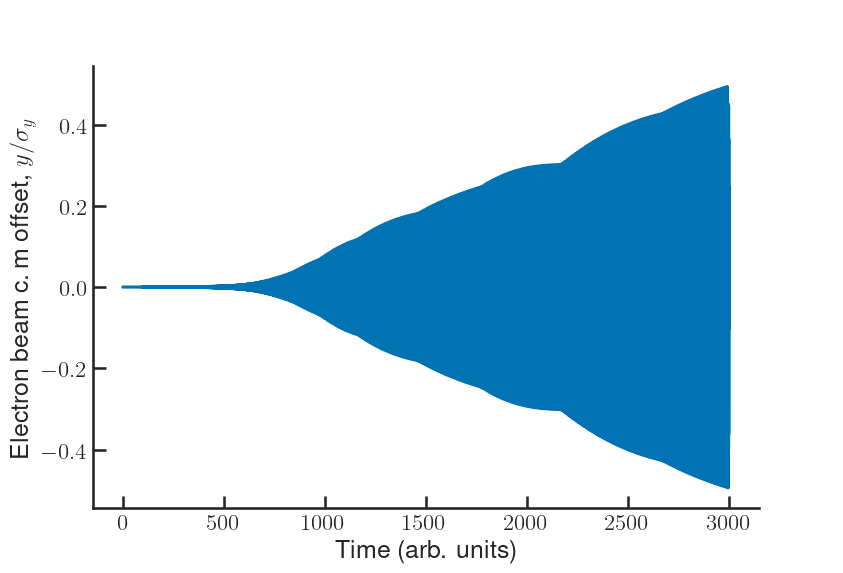

In [4]:
%matplotlib inline
fig, ax  = plt.subplots(1, 1)
def plot_offset(ax, mean_y, sigma_y, samples=1, time_scaling=1, **mpl_kwargs):
    turns = np.array(range(0, len(mean_y)))/H_RF/n_segments
    ax.plot(time_scaling*turns[::samples],
        mean_y[::samples]/sigma_y, **mpl_kwargs)
    ax.set_ylabel('Electron beam c.$\,$m offset, $y/\sigma_y$')
    ax.set_xlabel('Time (arb. units)')
    # signal = np.abs(hilbert(np.pad(mean_y/sigma_y, 500, mode='constant', constant_values=0)))
    # rx = fit_exponential_risetime(signal,
    #                       min_level=.01, 
    #                       smoothing_window_size=50*int(n_segments/1), 
    #                       start_from_0=False,
    #                       matplotlib_axis = None,
    #                      min_n_risetimes=1.)
    return 0
# mean_y1 = np.load('CO_mean_y.npy')
# mean_y2 = np.load('CO2_mean_y.npy')
# mean_y3 = np.load('mix_mean_y.npy')

# plot_offset(ax, mean_y3, sigma_y[0], samples=150, color=palette[2], label='gas mixture' )
# plot_offset(ax, mean_y2, sigma_y[0], samples=150, color=palette[1], label='$\mathrm{CO}_2^2$' )
# plot_offset(ax, mean_y1, sigma_y[0], samples=150, color=palette[0], label='$\mathrm{CO}^+$' )
            # label='$\mathrm{CO}^+$'
           # )

plot_offset(ax, mean_y_beam, sigma_y[0], samples=100, color=palette[0],
            # label='$\mathrm{CO}^+$'
           )
        
# ax.set_xlim(0, 1000)
# ax.set_ylim(-0.7, 0.7)
plt.figlegend()
    
    # risetime, amplitude, start, fit_start, until = res
# ax.title.set_text('Risetime {:1d} turns'.format(int(risetime/H_RF/n_segments*1)))
# print('Growth time (exponential) in turns {:.1f}'.format(rx/n_segments/H_RF*100))
# ax.set_ylim(-.75, 1)
# plt.savefig('/home/gubaidulin/Pictures/work/BII_PRAB/gas_mix_offset.pdf')

(416,)
(416,)


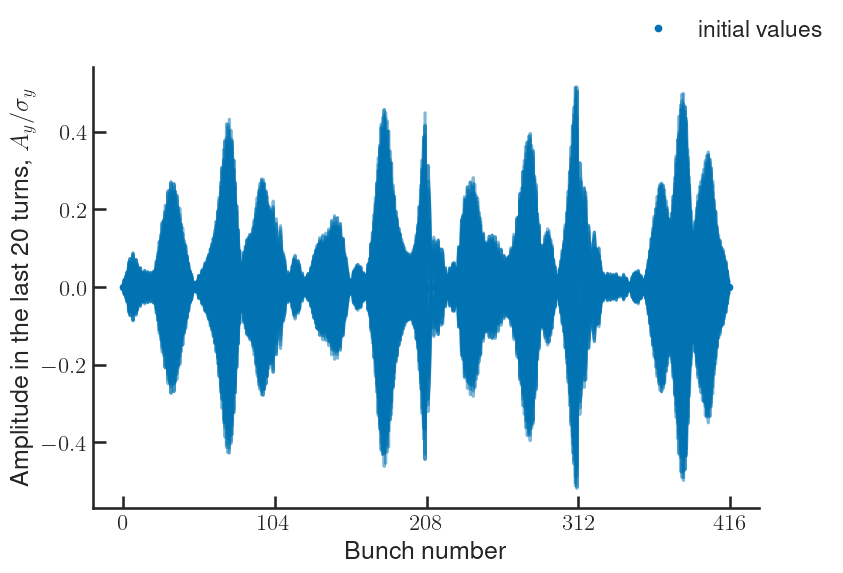

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
print(max_mean_y.shape)

def plot_last_ampl(ax, means, sigma_y0, h_rf = 416):
    n_bunches = means.shape[0]
    n = np.linspace(0, n_bunches-1, n_bunches)
    for i in range(0, 20):
        ax.plot(n, means[:, -i]/sigma_y0, color=palette[0], alpha=0.5)
    ax.plot(n, means[:, 0]/sigma_y0, label = 'initial values', lw=0, marker='.')
    ax.set_ylabel('Amplitude in the last 20 turns, $A_y/\sigma_y$')
    ax.set_xlabel('Bunch number')
    ax.set_xticks([0, int(h_rf/4), int(2*h_rf/4), int(3*h_rf/4), h_rf])
    return 0

plot_last_ampl(ax, means, sigma_y[0])

plt.figlegend()
# plt.savefig('/home/gubaidulin/Pictures/work/BII_PRAB/gas_mix_wavepattern.pdf')
os.system('mkdir -p {:}'.format(FOLDER+'Figures'))
print(max_mean_y.shape)

(0.0, 150.0)

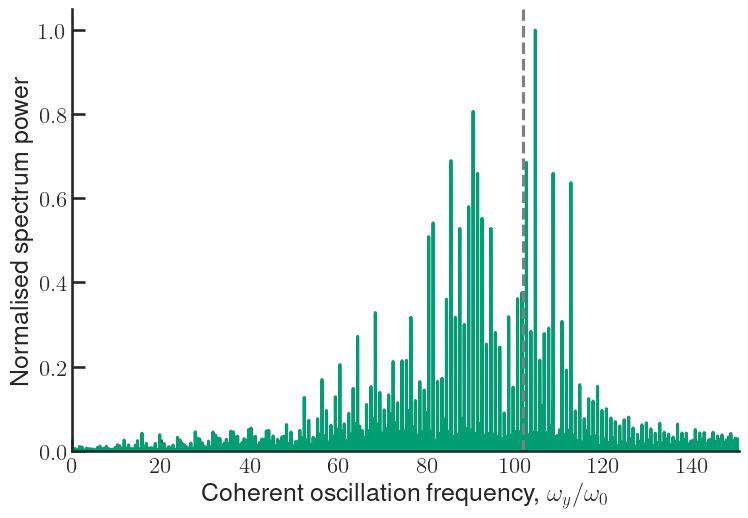

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
plot_fft(ax, mean_y_beam[:], f_sampling=H_RF, n_segments = n_segments, color=palette[2])
ax.axvline(101.4, color='grey', linestyle='dashed')
ax.set_xlim(0, 150)
# plt.figlegend()
# plt.savefig('/home/gubaidulin/Pictures/work/BII_PRAB/gas_mix_spectrum.pdf')

# Single bunch and ions

0

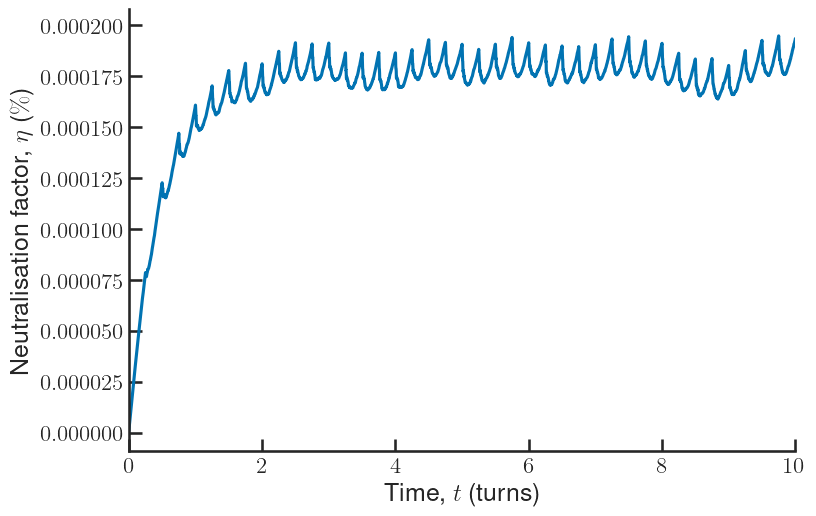

In [7]:
fig, ax = plt.subplots(1, 1)
plot_ion_density(ax, n_ion_macroparticles, n_segments=25)

In [16]:
sig_x = np.mean(sigma_x_ion[:100])
sig_y = np.mean(sigma_y_ion[:100])
print('Ion beam rms sizes are {:.1e}, {:.1e}'.format(sig_x, sig_y))
L_sep = 0.85
L_bunch=4*SIGMA_Z
def get_M_e(omega_i, L_sep=0.85, L_bunch=4*SIGMA_Z):
    omega_i_b = omega_i*np.sqrt(L_sep/L_bunch)
    phi_b = omega_i_b*L_bunch/c
    beta_b = c/omega_i_b
    M_e = np.array([[np.cos(phi_b), beta_b*np.sin(phi_b)], [-1/beta_b*np.sin(phi_b), np.cos(phi_b)]])
    return M_e 
@np.vectorize
def get_omega_i(sig_x, sig_y, A=28, intensity_per_bunch=int(1e9), L_sep=0.85):
    return c*np.sqrt(4*intensity_per_bunch*r_u/(3*L_sep*sig_x*(sig_y+sig_x)*A)), c*np.sqrt(4*intensity_per_bunch*r_u/(3*L_sep*sig_y*(sig_y+sig_x)*A))  
@np.vectorize
def get_omega_e(sigma_x, sigma_y, Sigma_I, n_g, N_e, gamma_r):
    return c*np.sqrt(4*Sigma_I*n_g*N_e*r_e/(gamma_r*sigma_x*(sigma_y+sigma_x))), c*np.sqrt(4*Sigma_I*n_g*N_e*r_e/(gamma_r*sigma_y*(sigma_y+sigma_x)))

omega_i_x, omega_i_y = get_omega_i(sig_x,
                                   sig_y,
                                   L_sep=L_sep,
                                   A=28,
                                   intensity_per_bunch=0.8*INTENSITY_PER_BUNCH
                                  )
sig_e_x, sig_e_y = sigma_x[0], sigma_y[0]
omega_e_x, omega_e_y = get_omega_e(sig_e_x,
                                   sig_e_y,
                                   Sigma_I=1.22e-22,
                                   n_g=2.4e13,
                                   N_e=INTENSITY_PER_BUNCH, gamma_r=GAMMA
                                  )

print('Bunch length in SOLEIL-II is {:.2f} metres'.format(L_bunch))
M_sep  = np.array([[1, L_sep],[0, 1]])
print('Electron beam rms sizes are {:.1e}, {:.1e}'.format(sig_e_x, sig_e_y))
print('Electron beam rms sizes calculated from emittance and betafunctions should be {:.1e}, {:.1e}'.format(np.sqrt(EPSILON_X*BETA_X_SMOOTH), np.sqrt(EPSILON_Y*BETA_Y_SMOOTH)))
print('Betafunctions {:.2f}, {:.2f}'.format(BETA_X_SMOOTH, BETA_Y_SMOOTH))
print('Emittances {:.1e}, {:.1e}'.format(EPSILON_X, EPSILON_Y))

M_e = get_M_e(omega_i_y, L_sep=L_sep, L_bunch = L_bunch)
print(f'Ions are trapped {np.abs(np.trace(M_sep@M_e)):.2f} < 2')
print('Betatron tunes are {0:.1f}, {1:.1f}'.format(Q_X, Q_Y))
print('Ion bounce tunes are {0:.1f}, {1:.1f}'.format(omega_i_x/OMEGA_REV, omega_i_y/OMEGA_REV))
print('Electron bounce tunes are {0:.3f}, {1:.3f}'.format(omega_e_x/OMEGA_REV, omega_e_y/OMEGA_REV))
def get_t_of_bunch_n(n, omega_e, omega_i, L_sep):
    return 2*Q_Y*OMEGA_REV/(n**2*omega_e**2*omega_i*L_sep/c)
print('The predicted instability growth time for the simulation parameters is {:.2e} turns'.format(get_t_of_bunch_n(416, omega_e_y, omega_i_y, L_sep=0.85)*2*pi*OMEGA_REV))
print('Relativistic gamma is {:.1f}'.format(GAMMA))
print(f'Trapping criterion {omega_i_y/c*L_sep:.2f} < 2')

Ion beam rms sizes are 1.9e-05, 8.9e-06
Bunch length in SOLEIL-II is 0.01 metres
Electron beam rms sizes are 2.2e-05, 9.9e-06
Electron beam rms sizes calculated from emittance and betafunctions should be 2.2e-05, 9.9e-06
Betafunctions 5.58, 3.92
Emittances 8.3e-11, 2.5e-11
Ions are trapped 0.18 < 2
Betatron tunes are 54.2, 18.3
Ion bounce tunes are 61.4, 88.9
Electron bounce tunes are 0.016, 0.023
The predicted instability growth time for the simulation parameters is 1.80e+00 turns
Relativistic gamma is 5382.6
Trapping criterion 1.34 < 2


2.1656104e-05 2.1520687721353146e-05
9.926851e-06 9.879676108051316e-06


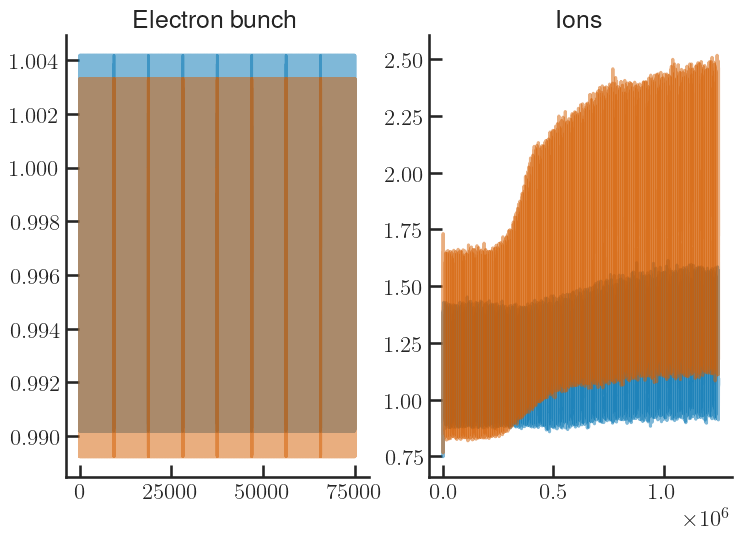

In [17]:
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
# fig, (ax_el, ) = plt.subplots(1, 1)
ax_el.title.set_text('Electron bunch')
ax_ions.title.set_text('Ions')

ax_ions.plot((sigma_x_ion)/sigma_x[0], color='b', label='$\langle x \\rangle$', alpha=0.5)
ax_ions.plot((sigma_y_ion)/sigma_y[0], color='r', label='$\langle y \\rangle$', alpha=0.5)
ax_el.plot(sigma_x/sigma_x[0], color='b', alpha=0.5, label='horizontal')
ax_el.plot(sigma_y/sigma_y[0], color='r', alpha=0.5, label='vertical')
# ax_el.set_ylim(.9, 1.1)
# ax_ions.set_ylim(.5, 3.)
print(sigma_x[0], np.sqrt(EPSILON_X*BETA_X_SMOOTH))
print(sigma_y[0], np.sqrt(EPSILON_Y*BETA_Y_SMOOTH))

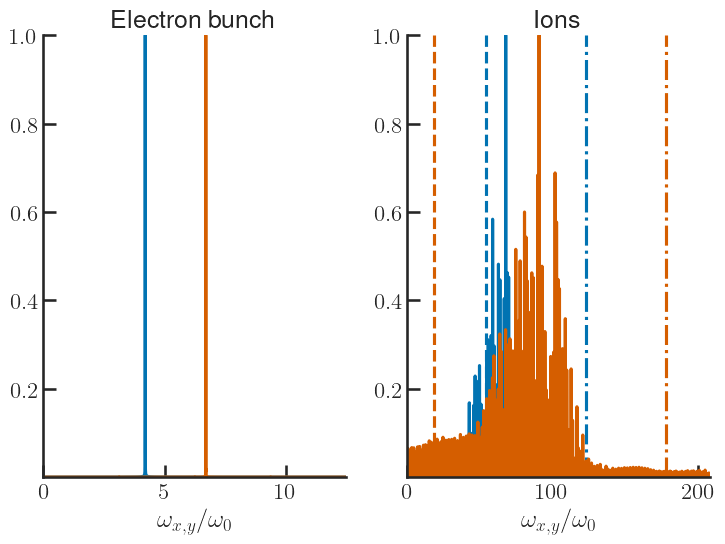

In [18]:
%matplotlib inline
f_0 = c/CIRCUMFERENCE
N_SEGMENTS = 25
f_s = f_0*N_SEGMENTS
fft_mean_x = np.abs(rfft(mean_x[:]-np.mean(mean_x[:])))
fft_mean_y = np.abs(rfft(mean_y[:]-np.mean(mean_y[:])))

fftfreq_mean_x = f_s*rfftfreq(mean_x[:].shape[0])/f_0
fftfreq_mean_y = f_s*rfftfreq(mean_y[:].shape[0])/f_0
f_s_ions = f_0*416
fft_mean_x_ion = np.abs(rfft(mean_x_ion[:]-np.mean(mean_x_ion[:])))
fft_mean_y_ion = np.abs(rfft(mean_y_ion[:]-np.mean(mean_y_ion[:])))

fftfreq_mean_x_ion = f_s_ions*rfftfreq(mean_x_ion[:].shape[0])/f_0
fftfreq_mean_y_ion = f_s_ions*rfftfreq(mean_y_ion[:].shape[0])/f_0
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
for ax in (ax_el, ax_ions):
    ax.axvline(Q_Y, color='r', linestyle='dashed')
    ax.axvline(Q_X, color='b', linestyle='dashed')
    ax.set_xlabel('$\omega_{x,y}/\omega_0$')
    ax.axvline(2*omega_i_x/OMEGA_REV, color='b', linestyle='dashdot')
    ax.axvline(2*omega_i_y/OMEGA_REV, color='r', linestyle='dashdot')
    ax.set_ylim(1e-3, 1)
ax_el.set_xlim(0, .5*f_s/f_0)
ax_ions.set_xlim(0, 416//2)    
ax_el.plot(fftfreq_mean_x, fft_mean_x/np.max(fft_mean_x))
ax_el.plot(fftfreq_mean_y, fft_mean_y/np.max(fft_mean_y), color='r')

ax_ions.plot(fftfreq_mean_x_ion, fft_mean_x_ion/np.max(fft_mean_x_ion))
ax_ions.plot(fftfreq_mean_y_ion, fft_mean_y_ion/np.max(fft_mean_y_ion), color='r')
ax_el.title.set_text('Electron bunch')
ax_ions.title.set_text('Ions')


[0.00000000e+00 5.54666667e-03 1.10933333e-02 ... 2.07988907e+02
 2.07994453e+02 2.08000000e+02]


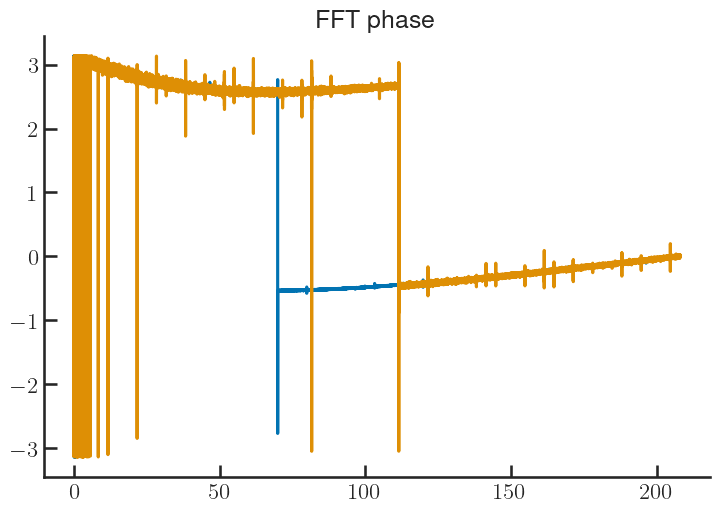

In [19]:
fig, ax = plt.subplots(1, 1)
ax.title.set_text('FFT phase')
fft_x = rfft(mean_x[:]-np.mean(mean_x[:]))
fft_y = rfft(mean_y[:]-np.mean(mean_x[:]))
fft_phase_x = np.angle(fft_x)# np.arctan2(fft_x.real, fft_x.imag)
fft_phase_y = np.angle(fft_y)#np.arctan2(fft_y.real, fft_y.imag)
fftfreq_mean_x = f_s_ions*rfftfreq(mean_x[:].shape[0])/f_0
fftfreq_mean_y = f_s_ions*rfftfreq(mean_y[:].shape[0])/f_0
ax.plot(fftfreq_mean_x, fft_phase_x)
ax.plot(fftfreq_mean_y, fft_phase_y)
print(fftfreq_mean_y)

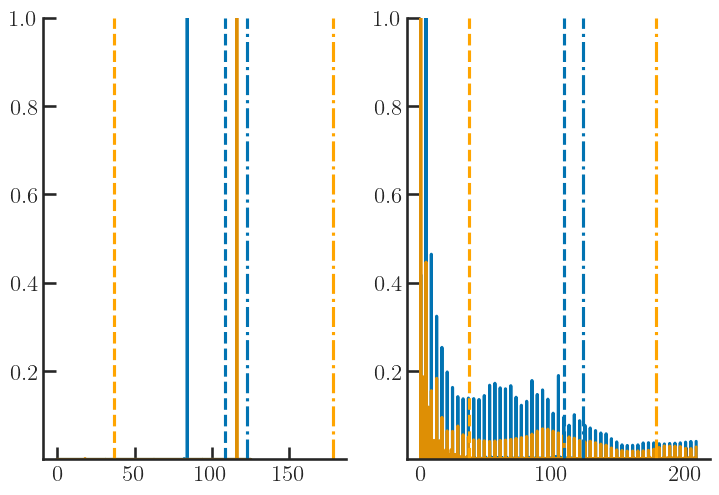

In [20]:

CIRCUMFERENCE = 354
f_0 = c/CIRCUMFERENCE
f_s = f_0*250
fft_sigma_x = np.abs(rfft(sigma_x-np.mean(sigma_x)))
fft_sigma_y = np.abs(rfft(sigma_y-np.mean(sigma_y)))

fftfreq_sigma_x = f_s*rfftfreq(sigma_x.shape[0])/f_0
fftfreq_sigma_y = f_s*rfftfreq(sigma_y.shape[0])/f_0
f_s_ions = f_0*416
fft_sigma_x_ion = np.abs(rfft(sigma_x_ion[100:]-np.mean(sigma_x_ion)))
fft_sigma_y_ion = np.abs(rfft(sigma_y_ion[100:]-np.mean(sigma_y_ion)))
fftfreq_sigma_x_ion = f_s_ions*rfftfreq(sigma_x_ion[100:].shape[0])/f_0
fftfreq_sigma_y_ion = f_s_ions*rfftfreq(sigma_y_ion[100:].shape[0])/f_0
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
ax_el.plot(fftfreq_sigma_x, fft_sigma_x/np.max(fft_sigma_x))
ax_el.plot(fftfreq_sigma_y, fft_sigma_y/np.max(fft_sigma_y))
ax_ions.plot(fftfreq_sigma_x_ion, fft_sigma_x_ion/np.max(fft_sigma_x_ion))
ax_ions.plot(fftfreq_sigma_y_ion, fft_sigma_y_ion/np.max(fft_sigma_y_ion))
for ax in [ax_el, ax_ions]:
    ax.axvline(Q_X*2, color='b', linestyle='dashed')
    ax.axvline(Q_Y*2, color='orange', linestyle='dashed')           
    ax.axvline(2*omega_i_x/OMEGA_REV, color='b', linestyle='dashdot')
    ax.axvline(2*omega_i_y/OMEGA_REV, color='orange', linestyle='dashdot')
    ax.set_ylim(1e-3, 1)
    # ax.set_xlim(0, 150)    

In [21]:
print('Ions generated by one electron bunch in a single segment {:.1f}'.format(INTENSITY_PER_BUNCH*1.78e-22*2.4e13*CIRCUMFERENCE/n_segments))
particles_per_macroparticle = INTENSITY_PER_BUNCH*1.78e-22*2.4e13*CIRCUMFERENCE/n_segments
print('Number of ion macroparticles generated instead is 30.')

Ions generated by one electron bunch in a single segment 535.5
Number of ion macroparticles generated instead is 30.


# Elegant postprocessing

(-0.25, 0.25)

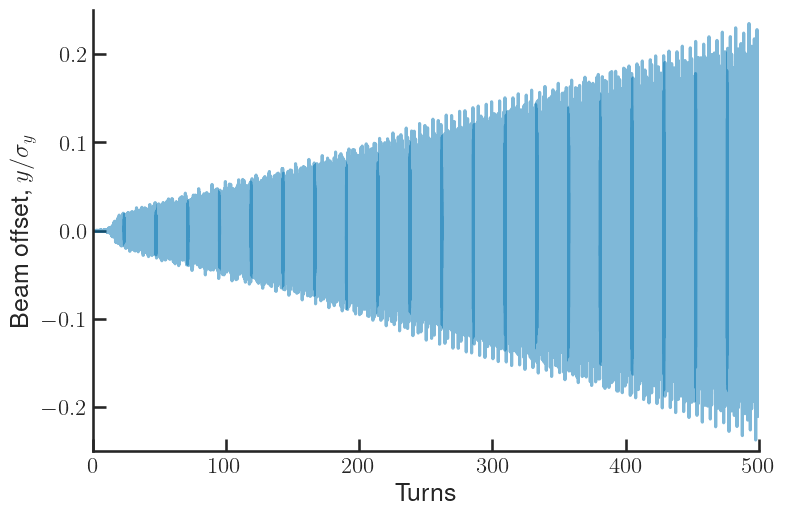

In [22]:

fig, ax = plt.subplots(1, 1)
Cy_array = []
for n in [1]:
    f = hp.File('/home/gubaidulin/scripts/tracking/elegant_scripts/ions_example_soleil_ii/ion{:}beam.hdf5'.format(n))    

    for page in range(1, len(f.keys())):
        Cy_array = np.concatenate((Cy_array, (f['page{:}'.format(int(page))]['columns']['Cy'][:])))
    f.close()
    Cy_array = np.array(Cy_array)
    turns = np.linspace(0, 2000, Cy_array.shape[0])
    ax.plot(turns, Cy_array/sigma_y[0], alpha=0.5)
ax.set_ylabel('Beam offset, $y/\sigma_y$')
ax.set_xlabel('Turns')
ax.set_xlim(0, 500)
ax.set_ylim(-.25, .25)

3000.0 1999.0


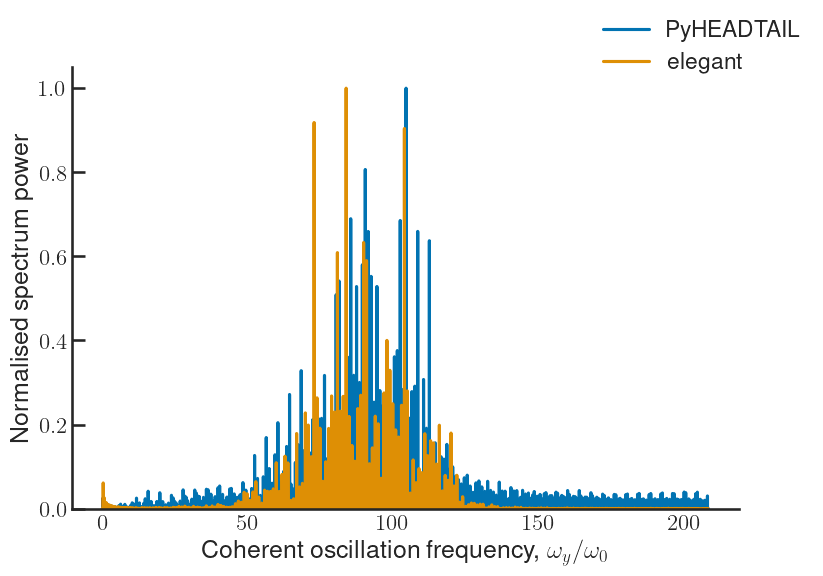

In [23]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
print(mean_y_beam.shape[0]/n_segments/H_RF, Cy_array.shape[0]/H_RF)
plot_fft(ax, mean_y_beam, f_sampling=H_RF, n_segments = n_segments, label='PyHEADTAIL')
plot_fft(ax, Cy_array, f_sampling=H_RF, n_segments = 1, label='elegant')
plt.figlegend()

In [25]:
f = hp.File('/home/gubaidulin/scripts/tracking/elegant_scripts/ions_example_soleil_ii/ion{:}fft.hdf5'.format(1))    
    # Cy_array = []
page=1
fftCy = (f['page{:}'.format(int(page))]['columns']['FFTCy'][:])
fftfreqCy = (f['page{:}'.format(int(page))]['columns']['f'][:])
# for page in range(1, len(f.keys())):
    # Cy_array = np.concatenate((Cy_array, (f['page{:}'.format(int(page))]['columns']['Cy'][:])))
f.close()
print(fftCy)


[9.65131132e-12 1.94167422e-11 1.96395227e-11 ... 7.49004920e-13
 9.02576349e-13 5.38119465e-13]


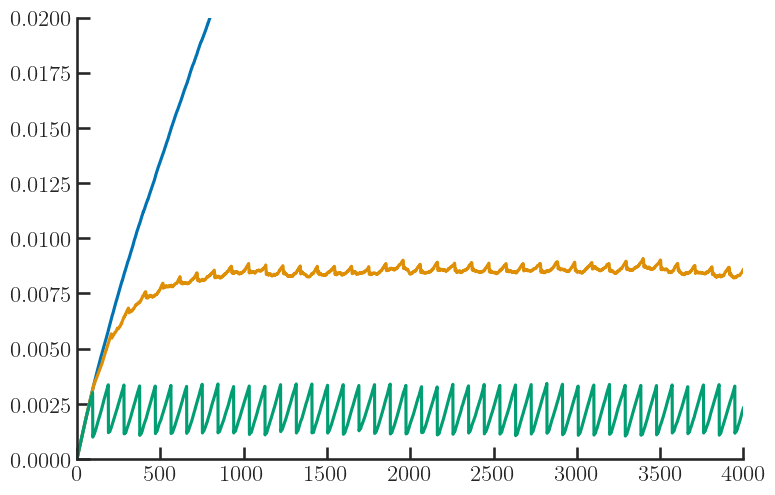

In [26]:
%matplotlib inline
folder_el = '/home/gubaidulin/scripts/tracking/elegant_scripts/ions_example_soleil_ii/'
fig, ax = plt.subplots(1, 1)
label_list = ['0 rf bucket', '1 rf bucket', '10 rf buckets']
n_g = 2.4e13
Sigma_I = 1.22e-22
circumference = 354
n_segments = 25
n_macroions = 30
n_ions_per_bunch = n_g*Sigma_I*circumference/n_macroions
for i in [1, 2, 3]:
    file_el = hp.File(folder_el+'ionDens{:}.hdf5'.format(int(i)))
    intensity_el = [0]
    for n in range(1, 200, 10):
        intensity_el = np.concatenate((intensity_el, file_el['page{:}'.format(int(n))]['columns']['nMacroIons'][:]))
#     np.save('/home/gubaidulin/scripts/tracking/elegant_scripts/saved_output/elegant_gaps{:.1f}'.format(i), intensity_el)
    file_el.close()
    ax.plot(100*n_ions_per_bunch*intensity_el, label=label_list[i-1])
    ax.set_xlim(0, 4e3)
    ax.set_ylim(0, 2e-2)
# Wang formula
# n = np.linspace(1, 80*4, 80*4, dtype=np.int64)
# ax.plot(n, f_ions(n, omega_I=100*OMEGA_REV, n_empty=0),  color='navy', label='0 rf buckets (analytical)', linestyle='dashed')
# ax.plot(n, f_ions(n, omega_I=100*OMEGA_REV, n_empty=1),  color='orange', label='1 rf bucket (analytical)', linestyle='dashed')
# ax.plot(n, f_ions(n, omega_I=100*OMEGA_REV, n_empty=10), color='darkgreen', label='10 rf buckets (analytical)', linestyle='dashed')
# plt.figlegend(title='4 gaps of length', ncol=2)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/bii_pyht_tracking/Results/TDR/n_mp=5.0e+03,gap_length=1,n_gaps=4,n_segments=25,int_model=strong,smooth=True,charge_variation=0.0,pressure_variation=25.0,pressure=3.2e+12,beam_current=5.0e-01/IM(ind=1).h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

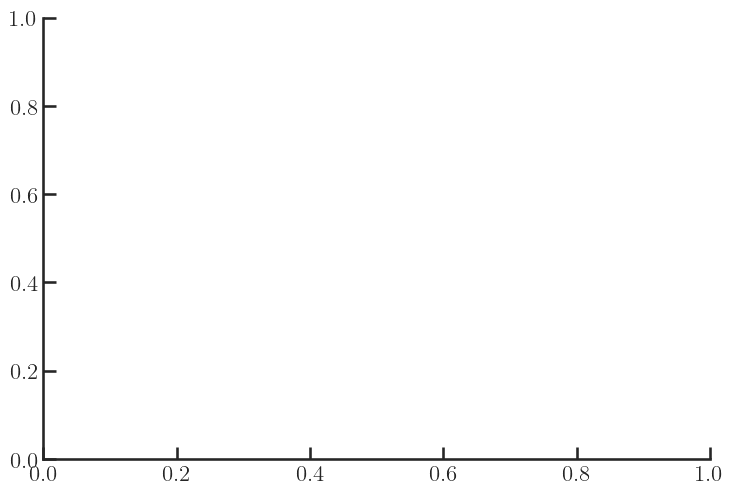

In [27]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
# for i, n_gaps in enumerate([4, 8]):
    # for j, gap_length in enumerate([1, 2]):
for j, charge_variation in enumerate([0.0, 1.0, 2.0, 4.0, 8.0, 16.0]):
# for i, pressure in enumerate([1.2e13, 2.4e13, 4.8e13, 7.2e13]):
# for i, model in enumerate(['strong']):
    gap_length = 1
    n_gaps = 4
    n_segments = 25
    # charge_variation= 0
    model = 'strong'
    # pressure_variation=0
    pressure = 3.2e12
    beam_current = 500e-3
    palette = sbs.color_palette('colorblind')
    FOLDER = '/home/gubaidulin/scripts/tracking/bii_pyht_tracking/Results/TDR/'
    FOLDER += 'n_mp={:.1e},gap_length={:},n_gaps={:},n_segments={:},int_model={:},smooth=True,charge_variation={:},pressure_variation={:},pressure={:.1e},beam_current={:.1e}/'.format(
                                                                                                                  n_macroparticles,
                                                                                                                  gap_length,
                                                                                                                  n_gaps,
                                                                                                                  n_segments,
                                                                                                                  model,
                                                                                                                  charge_variation,
                                                                                                                  pressure_variation,
                                                                                                                  pressure,
                                                                                                                  beam_current)

    filename = FOLDER+'IM(ind={0:}).h5'.format(int(1))

    file = hp.File(filename)
    filename = FOLDER+'IM(ind={0:}).h5'.format(int(1))
    n_ion_macroparticles = file['Bunch']['macroparticlenumber'][:]
    file.close()
    omega_I = omega_i_x
    print('ion bounce frequency is {:.1f} harmonic of revolution frequency'.format(omega_I/OMEGA_REV))
    L_wang = c/(omega_I/2/np.pi)
    L_diff = (np.tan(np.pi/2*np.exp(-1))*omega_I/(2*c))**-1
    print("Diffusion length is {:.2f}, Wang length is {:.2f}".format(L_diff, L_wang))


    omega_I = omega_i_y
    print('Loss of ions in a single gap {:.2f} {:.2f}'.format(np.exp(-0.85/(c/(omega_I/2/np.pi)))**3, (2/pi*np.arctan(omega_I*0.85/(2*c)))**3))
    scaling_coef = 100*542/INTENSITY_PER_BUNCH
    ax.plot(scaling_coef*n_ion_macroparticles,
            # label='gap number {:}'.format(n_gaps),
            label='gap number {:} '.format(n_gaps)+'gap length {:} rf buckets'.format(gap_length),
            # label='charge variation {} \%'.format(charge_variation),
            color=palette[i*2+j])
    x = np.linspace(0, 50, dtype=np.int64)
    ax.plot(x*104-1, scaling_coef*f_ions(x, n_empty=gap_length, omega_I=100*OMEGA_REV, n_gaps=n_gaps), color=palette[i*2+j],
            #linestyle='dashed', label='formula {:} rf buckets'.format(gap_length), marker=None
           )

    # ax.plot(x*104-1, 100*542/INTENSITY_PER_BUNCH*f_ions_Wang(x, n_empty=gap_length, omega_I=100*OMEGA_REV, n_gaps=n_gaps), color=palette[i], linestyle='dashed', label='Wang {:} rf buckets'.format(gap_length), marker=None)
    # ax.plot(x*104-1, f_ions3(x, n_empty=1), label='Magic formula v2', marker=None)

# print(np.exp(-0.85/11.15))
ax.set_xlim(0, 5e3)
ax.set_ylim(0, .1)
ax.set_ylabel('Neutralisation factor, $\eta$ (\%)')
ax.set_xlabel('\# of electron bunches passed by')
plt.figlegend()
# ax.set_xticks([0, 104, 208, 312, 416, 520, 624])
ax.set_ylim(0, )
plt.savefig('gaps_ion_density.svg')

# Ion density analysis

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/bii_pyht_tracking/Results/TDR/n_mp=5.0e+03,n_mp_ions=1.0e+05,n_gaps=0.0e+00,n_segments=2.5e+01_every_104,int_model=weak/IM(ind=0).h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

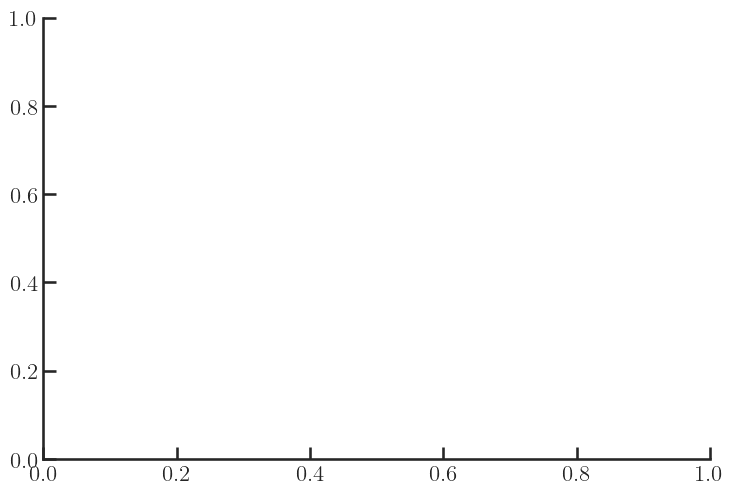

In [28]:
fig, ax = plt.subplots(1, 1)
colorblind = sbs.color_palette('colorblind')
colors_el = ['navy', 'darkred', 'darkgreen']
n_macroparticles_ions = 1e5
for n in [0, 1, 10]:
    path = '/home/gubaidulin/scripts/tracking/bii_pyht_tracking/Results/TDR/'
    intensity_el = 5/2*np.load('/home/gubaidulin/scripts/tracking/elegant_scripts/saved_output/elegant_gaps={:}.npy'.format(int(n)))
    if n!=10:
        folder = 'n_mp={:.1e},n_mp_ions={:.1e},n_gaps={:.1e},n_segments={:.1e}_every_104,int_model=weak/'.format(n_macroparticles, n_macroparticles_ions, n, n_segments)
        filename=path+folder+'IM(ind=0).h5'
        file = hp.File(filename)
        intensity = file['Bunch']['macroparticlenumber'][:]
        file.close()
        c_ind=n
        ax.plot(intensity[:8000], label='{:} rf buckets'.format(int(n)), color=colorblind[c_ind])
        
    else:
        c_ind = 2
        intensity = np.load('/home/gubaidulin/intensity_pyht_gaps=10.npy')
        ax.plot(intensity[:], label='{:} rf buckets'.format(int(n)), color=colorblind[c_ind])        
    ax.plot(intensity_el, label='{:} rf buckets (elegant)'.format(int(n)), color=colors_el[c_ind], alpha=0.8)
    
ax.title.set_text('Gaps in SOLEIL II')
ax.set_xlabel('Number of passed electron bunches')
ax.set_ylabel('Ion intensity (arb. units)')
# ax.xaxis.set_major_locator(MultipleLocator(416))
# ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_xlim(0, 8e3)
ax.set_ylim(0,1.2e4)
plt.figlegend(loc='upper right')
# plt.savefig('/home/gubaidulin/gaps_in_soleilII.pdf')
# plt.savefig('/home/gubaidulin/gaps_in_soleilII.svg')

124734.96327152527
473597781.7118189


/tmp/ipykernel_244521/821278285.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return 2*Q_y*omega_0/(n**2*omega_e**2*omega_i*L_sep/c)
/tmp/ipykernel_244521/821278285.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, )


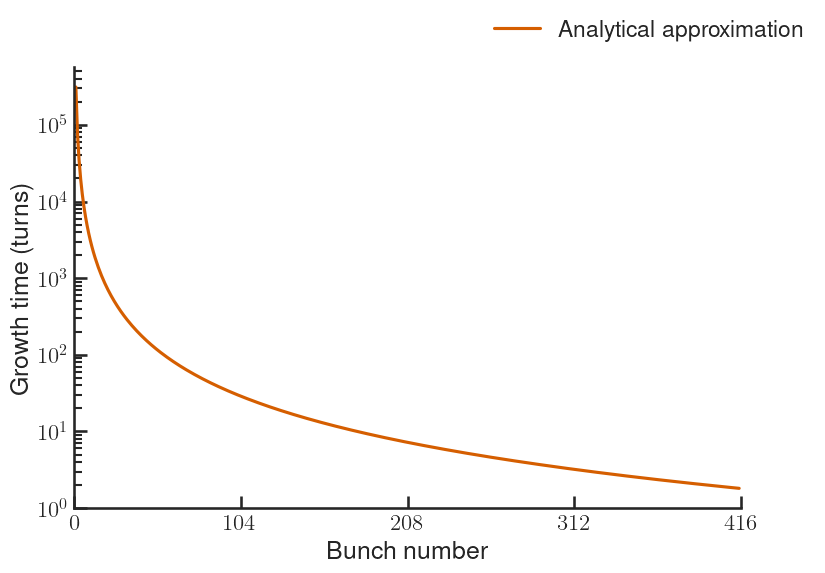

In [30]:
fig, ax = plt.subplots(1, 1)
def get_t_of_bunch_n(n, omega_e, omega_i, omega_0, L_sep=0.85, Q_y=18.2):
    return 2*Q_y*omega_0/(n**2*omega_e**2*omega_i*L_sep/c)
n = np.linspace(0, 415, 416)
# omega_e_y = 63093.07877837223
# omega_i_y = 170579231.140797
print(omega_e_y)
print(omega_i_y)
t = get_t_of_bunch_n(n, omega_e_y, omega_i_y, OMEGA_REV,  L_sep=L_sep, Q_y=Q_Y)
ax.semilogy(n, t*2*pi*OMEGA_REV, color='r', label='Analytical approximation')
# ax.semilogy(risetime_exonential[:-50], linewidth=0, marker='.', color='b', label='Tracking results, w. $\exp{(t/t_0)}$ fit')
# ax.semilogy(risetime_sqrt[:], linewidth=0, marker='.', label='Tracking results, w. $\exp{(\sqrt{t/t_0})}$ fit', color='r')
ax.set_xticks([0, 104, 208, 312, 416])
ax.set_xlim(0, 416)
ax.set_ylim(0, )
ax.set_xlabel('Bunch number')
ax.set_ylabel('Growth time (turns)')
plt.figlegend()
# plt.savefig('Figures/Growthtimes_comparison.svg')
# plt.savefig('Figures/Growthtimes_comparison.pdf')

In [32]:
x, xp, y, yp, z, dp =  read_ion_particles(0, 0)
fig, axlist = plt.subplots(1, 2)
print(x.shape, xp.shape)
shape = np.min([x.shape[0], y.shape[0], xp.shape[0], yp.shape[0]])
x=x[:shape]
xp=xp[:shape]

y=y[:shape]
yp=yp[:shape]

axlist[0].scatter(x/sigma_x[0], xp*c/omega_i_x/sigma_x[0], alpha=0.05, color='b', marker='.')
# sbs.kdeplot(x/sigma_x[0], xp*c/omega_i_x/sigma_x[0], color='b', ax = axlist[0], levels=10)
axlist[1].scatter(y/sigma_y[0], yp*c/omega_i_y/sigma_y[0], alpha=0.05, color='r', marker='.')
# sbs.kdeplot(y/sigma_y[0], yp*c/omega_i_y/sigma_y[0], color='r', ax=axlist[1], levels=10)

print(x.shape)
axlist[0].set_xlabel('Horizontal position, $x/\sigma_{e_x}$')
axlist[0].set_ylabel('Horizontal momentum, $p_x$ (arb. units)')
axlist[1].set_xlabel('Vertical position, $y/\sigma_{e_y}$')
axlist[1].set_ylabel('Vertical momentum, $p_y$ (arb. units)')

for ax in axlist:
    # ax.set_xlim(-5, 5)
    # ax.set_ylim(-1e-23, 1e-23)
    pass
plt.savefig('Figures/transverse_phase_space.svg')
plt.savefig('Figures/transverse_phase_space.pdf')

TypeError: read_ion_particles() missing 1 required positional argument: 'folder'

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/bii_pyht_tracking/Results/TDR/n_mp=5.0e+03,gap_length=1,n_gaps=4,n_segments=25,int_model=strong,smooth=True,charge_variation=0.0,pressure_variation=25.0,pressure=3.2e+12,beam_current=5.0e-01/IM(ind=1).h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

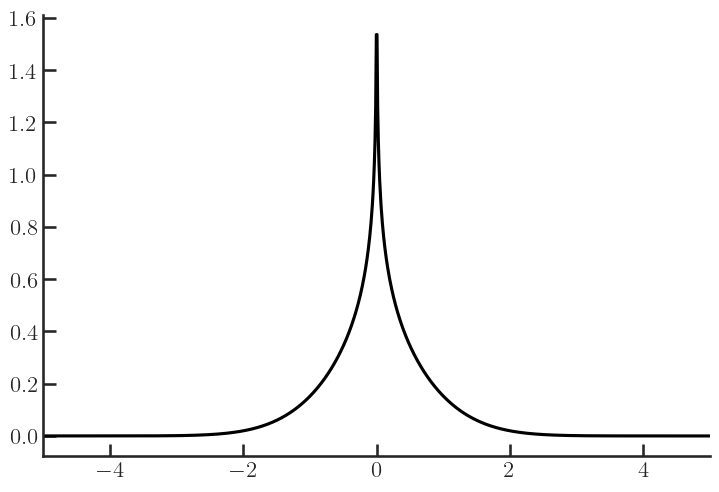

In [33]:
fig, ax = plt.subplots(1, 1)
def get_dist(x, sig_x):
    return 1/(pi*np.sqrt(2*pi)*sig_x)*k0(x**2/(2*sig_x)**2)*np.exp(-x**2/(2*sig_x)**2)
ax.set_xlim(-5, 5)
x = np.linspace(-5, 5, 1000)
y = get_dist(x, 1)
ax.plot(x, y, linestyle='solid', label='Analytical (P.F. Tavares)', color='black')
for i in range(500, 501, 2):
    x, xp, y, yp, z, dp =  read_ion_particles(1, i, folder=FOLDER)
    ax = sbs.kdeplot((x-np.mean(x))/sigma_x[0],  alpha=1, color='b')
    ax = sbs.kdeplot((y-np.mean(y))/sigma_y[0],  alpha=1, color='r')
ax.set_xlabel('$u/\sigma_u$')
plt.savefig('Figures/distribution_ions.svg')
plt.savefig('Figures/distribution_ions.pdf')
# plt.xlim(-5, 5)
# plt.ylim(0, )
# plt.title("Analytical distribution (Tavares)")
# plt.savefig('Figures/distribution_tavares.svg')
# plt.savefig('Figures/distribution_tavares.pdf')

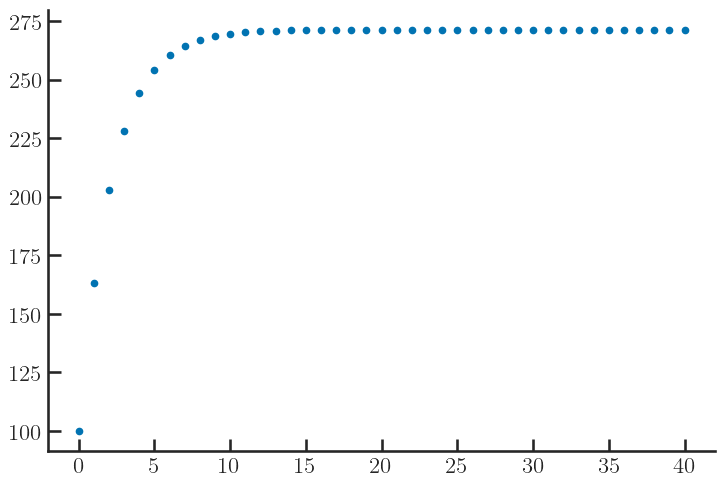

In [134]:
def f_fit(n, G, L_diff):
    # G, L_diff = popt
    L_gap = 0.85
    k = np.linspace(0, n, int(n+1))
    return G*np.sum(np.exp(-k*L_gap/L_diff))
f_fit = np.vectorize(f_fit, excluded={'G', 'L_diff'})
x = np.linspace(0, 40, 41)
plt.plot(x, f_fit(x, 100, 1.85), lw=0, marker='.')

0.016067887
0.007741717
0.028450394
0.0043402277


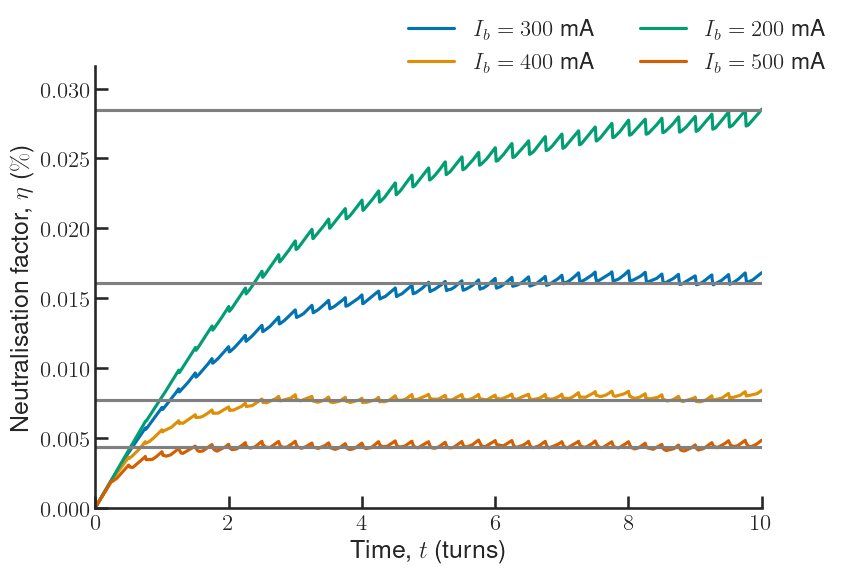

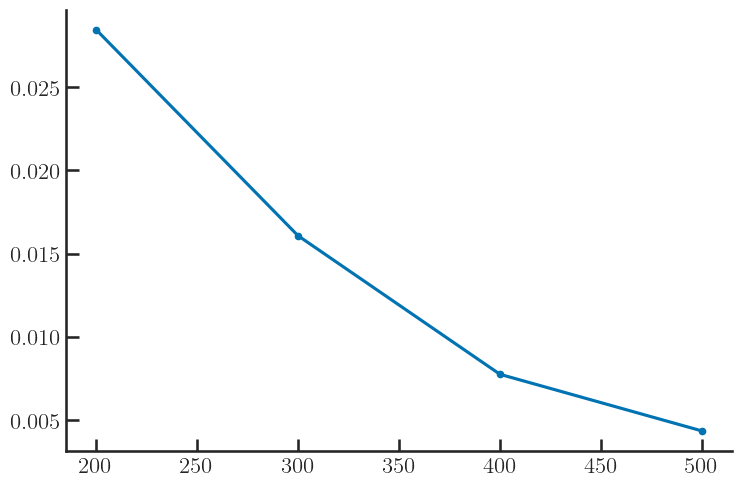

In [145]:
%matplotlib inline

n_macroparticles = 5e3
n_turns = 100
n_gaps = 4
gap_length = 1
n_segments = 25
pressure_variation = 0.0
# pressure = 2.9e12
pressure = 3.2e12
# pressure = 2.4e13
beam_current=500e-3
charge_variation = 0.0
# A = 44


A = 28
smooth = 'True'
palette = sbs.color_palette('colorblind')
fig, ax = plt.subplots(1, 1)
# for i, n_segments in enumerate([100, 150, 200]):
# for i, smooth in enumerate(['True', 'False']):
# for i, charge_variation in enumerate([0.0, 2.0, 4.0, 8.0]): 
# for pressure_variation in [1000.0, 500.0, 100.0, 50.0, 25.0]:
# for i, n_gaps in enumerate([2, 4, 8]):
# for i, pressure in enumerate([1.6e12, 3.2e12, 6.4e12, 9.6e12]):
for i, beam_current in enumerate([300e-3, 400e-3, 200e-3, 500e-3]):
# for i, gap_length in enumerate([1, 2, 4, 8]):
# for i, pressure in enumerate([9.6e12, 6.4e12, 3.2e12, 1.6e12]):
    FOLDER = '/home/gubaidulin/scripts/tracking/bii_pyht_tracking/Results/TDR/'
    FOLDER += 'n_mp={:.1e},gap_length={:},n_gaps={:},n_segments={:},int_model=strong,smooth={:},charge_variation={:},pressure_variation={:},pressure={:.1e},beam_current={:.1e},A={:}/'.format(
                                                                                                              n_macroparticles,
                                                                                                              gap_length,
                                                                                                              n_gaps,
                                                                                                              n_segments,
                                                                                                              smooth,
                                                                                                              charge_variation,
                                                                                                              pressure_variation,
                                                                                                              pressure,
                                                                                                              beam_current,
                                                                                                              A
    )
    mean_x_ion, sigma_x_ion, mean_xp_ion, mean_y_ion, sigma_y_ion, mean_yp_ion, mean_z_ion, mean_dp_ion, n_ion_macroparticles = read_ion_element(1, folder=FOLDER)
    mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(0,
                                                                                         n_macroparticles,
                                                                                         folder=FOLDER)
    # means = np.empty(shape=(H_RF, mean_y.shape[0]))
    # for bunch_number in range(0,H_RF):
    #     mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number,
    #                                                                                      n_macroparticles,
    #                                                                                      folder=FOLDER)
    #     means[bunch_number] = mean_y

    # mean_y_beam = means.flatten(order='F')
    # max_mean_y = np.max(means, axis=1)
    # plot_offset(ax, mean_y_beam, sigma_y[0], samples=50, time_scaling=pressure/2.9e12, alpha=0.75,
    #             # label = '$\Delta q_\mathrm{rms}= $'+'\,${:}\,\%$'.format(int(charge_variation))
    #             # label = 'Smooth approximation {:}'.format(smooth)
    #             # label = f'{n_segments} segments'
    #             # label = f'Res. gas density {pressure:.1e}'
    #             label = f'$I_b={int(beam_current*1e3)}$ mA'
    #             # label = f'$p={pressure/3.2e12:.1f}p_0$'
    #             # label = f'$\Delta_p={pressure_variation:.1f} \%$'
    #            )

    plot_ion_density(ax, n_segments*n_ion_macroparticles[:416*50], n_segments=n_segments, color=palette[i], alpha=1.0,
                     label=f'$I_b={int(1e3*beam_current):}$ mA',
                     # label='$n_\mathrm{gaps}=$'+f' ${n_gaps}$'
                     # label='$n_\mathrm{empty}=$'+f' ${gap_length}$'
                     # label='{:} segments'.format(n_segments)
                     # label = '$\Delta q_\mathrm{rms}= $'+'\,${:}\,\%$'.format(int(charge_variation))
                    )
    h_rf = 416
    data_length = (n_segments*n_ion_macroparticles[:416*50]).shape[0]
    n_ions_per_bunch = n_g*Sigma_I*circumference/n_segments/n_macroions
    n_bunches_passed = np.linspace(0, data_length/h_rf, int(data_length))
    eta = 100*n_ions_per_bunch*(n_segments*n_ion_macroparticles[:416*50])
    print(np.mean(eta[-100:]))
    # ax.plot(n_bunches_passed, eta, **mpl_kwargs)

    #     n_g = pressure
#     Sigma_I = 1.78e-22
# #     Sigma_I = 1e-22
#     circumference = 354
#     n_segments = n_segments
#     n_macroions = 31
#     n_ions_per_bunch = n_g*Sigma_I*circumference/n_segments/n_macroions
#     eta_factor = 100*n_ions_per_bunch
    
#     k = np.linspace(0, n_turns*n_gaps-1, n_turns*n_gaps, dtype=np.int64)
#     print(beam_current)
#     f = f_ions(k,
#             #    omega_I=103.1*OMEGA_REV*(beam_current/500e-3)**2.2,
#                omega_I=205*OMEGA_REV*(beam_current/500e-3)**2.,
#                n_empty=gap_length,
#                L_sep = 0.85,
#                n_gaps=n_gaps, 
#                h_rf = 416,
#                N_ions=n_macroions,
#                approximation='exp'
#               )
#     print(f'Diffusion length is {2*np.pi*c/(205*OMEGA_REV*(beam_current/.5)**2)}')
#     plt.plot(k/n_gaps, n_segments*eta_factor*f, color=palette[i], ls='dashed',
#             #  label='Eq.\,(x) $n_\mathrm{gaps}=$'+f' ${n_gaps}$'
#             #  label='Eq.\,(x) $I_b={:}$ mA'.format(int(1e3*beam_current))
#             #  label='Eq.\,(x) $n_\mathrm{empty}=$'+f' ${gap_length}$'
#             label=None
#             )
plt.figlegend(ncol=2)
# ax.set_xlim(0, 1000)
ax.set_ylim(0, )
# ax.set_ylim(-0.25, 0.25)
ax.set_xlabel('Time, $t$ (turns)')
# ax.set_xlabel('Normalised time, $tp/p_0$ (normalised turns)')
# plt.savefig('/home/gubaidulin/Pictures/work/BII_PRAB/beam_current_ion_density.pdf')
# plt.savefig('/home/gubaidulin/Pictures/work/BII_PRAB/beam_current_ion_density.png')
curr = [200, 300, 400, 500]
eta = [0.028450394, 0.016067887, 0.007741717, 0.0043402277]
for e in eta:
    ax.axhline(e, color='grey')
plt.figure()
plt.plot(curr, eta, marker='.')

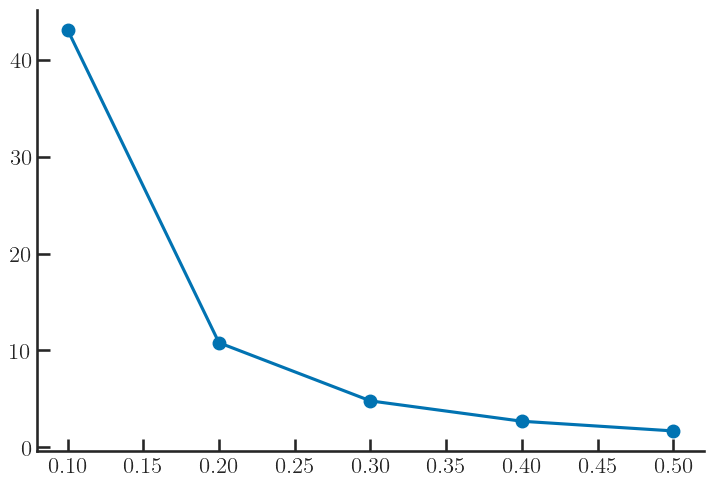

In [98]:
L_diff = [43.1, 10.8, 4.8, 2.7, 1.7]
I = np.linspace(0.1, .5, 5)
plt.plot(I, L_diff, marker='o')

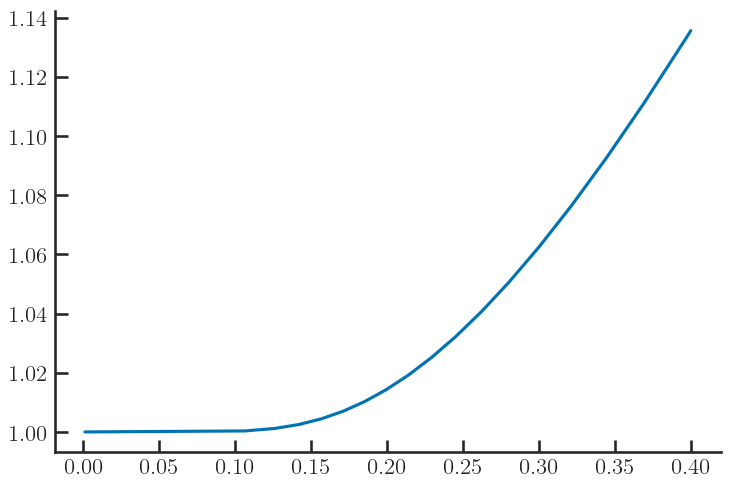

In [162]:
%matplotlib inline
x = np.linspace(0.001, 0.4, 10000)
rho = 1/(1-np.exp(-0.85/x))
plt.plot(x, rho)